# Quality Assurance (QA) Python Version

This notebook gives example uses of image based QA metrics in `qa`.

A large chunk of this code has been taken from Alex Daniel's `ukat` code: https://github.com/UKRIN-MAPS/ukat.

We'll start with some imports and general housekeeping.

Reference for tSNR: https://doi.org/10.1016/j.neuroimage.2005.01.007

In [1]:
import sys
sys.path.append('/Users/spmic/Documents/MATLAB/qa/')
print(sys.path)

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import Normalize
import nibabel as nib
from glob import glob


#from ukat.data import fetch
from fMRI_report_python.functions import snr
#from fMRI_report_python.functions.snr import some_function
#from functions import snr
from scipy.signal import detrend

# check packages
print(snr)
print(dir(snr))

['/Users/spmic/Documents/MATLAB/qa/fMRI_report_python/tutorials', '/Users/spmic/fsl/lib/python311.zip', '/Users/spmic/fsl/lib/python3.11', '/Users/spmic/fsl/lib/python3.11/lib-dynload', '', '/Users/spmic/fsl/lib/python3.11/site-packages', '/Users/spmic/Documents/MATLAB/qa/']
<module 'fMRI_report_python.functions.snr' from '/Users/spmic/Documents/MATLAB/qa/fMRI_report_python/functions/snr.py'>
['BayesianGaussianMixture', 'Isnr', 'Tsnr', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'nib', 'np', 'os']


In [2]:
# make the loading a bit easier inline
def load_data(inputdatafilename):
    #Function to load in data 
    #Needs an input arg
    data = nib.load(inputdatafilename)
    image = data.get_fdata()
    return image, data.affine

In [3]:
def process_data(imgm_cla, imgp_cla, imgm_affine, imgp_affine, core_filename, output_dir):

    # This is our big function
    # I had to condense all the functionality of the notebook into this one func, to make the for loop in the script easier
    # So, first it plots the mean images
    # Calculates iSNR
    # Calculates tSNR
    # Calculates tSNR in a patch ROI
    # Plots signal and std of signal in patch over time
    # Plots static spatial noise image
    # OUTPUTS: 
    # tSNR images saved as nii.gz
    # Lots of PNG images of every plot

    ############################## Plotting mean images
    # Set slice (3d) and time (4d)
    slice_index = round(imgm_cla.shape[2] * 2 / 3)
    print(f"Slice index: {slice_index}")
    time_point = 1
    tsnrScale = 125

    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(1, 2, figsize=(5, 5))  # Adjust figsize as needed

    # Plot imgm_cla
    axs[0].imshow(imgm_cla[:, :, slice_index, time_point].T, origin='lower', cmap='gray')
    axs[0].set_title(f'Classic magnitude (Slice {slice_index})')  # Set subplot title with slice index
    axs[0].axis(False)  # Turn off axis labels and ticks

    # Plot imgp_cla phase
    axs[1].imshow(imgp_cla[:, :, slice_index, time_point].T, origin='lower', cmap='gray')
    axs[1].set_title(f'Classic phase (Slice {slice_index})')  # Set subplot title with slice index
    axs[1].axis(False)  # Turn off axis labels and ticks

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

    # Assuming you have created a plot `plt` and want to save it as a PNG file
    output_filename = 'Mean_images.png'
    output_path = f"{OUTPUT_DIR}/{output_filename}"  # Construct the full output path
    fig.savefig(output_path, dpi=300)  # Save the plot as a PNG file with 300 dpi resolution
    plt.close()  # Close the plot to free up memory

    # montage plots
    rows = int(np.ceil(np.sqrt(imgm_cla.shape[2])))  # Number of rows (ceil of square root of number of slices)
    cols = int(np.ceil(imgm_cla.shape[2] / rows))  # Number of columns based on rows
    # Create a new figure for the montage
    fig = plt.figure(figsize=(10, 10))  # Adjust figsize as needed
    # Plot each slice as a subplot in the montage
    #print(f'Classic image has dimensions of {imgm_cla.shape[2]:.2f}.', file=output_file)
    #print("Classic image has dimensions of :", imgm_cla.shape[2], file=output_file)
    


    for i in range(imgm_cla.shape[2]):
        # Create a subplot for the current slice
        ax = fig.add_subplot(rows, cols, i + 1)  # i+1 because subplot indices start from 1
        # Display the current slice using imshow
        ax.imshow(imgm_cla[:, :, i, time_point], cmap='gray')  # Adjust colormap as needed
        ax.set_title(f"Slice {i}")  # Set title with slice index
        ax.axis('off')  # Turn off axis labels and ticks
    
    # Adjust layout and spacing of subplots
    fig.tight_layout(pad=0.5)

    # Save the montage as a PNG file
    output_filename = 'classic_mean_montage.png'
    output_path = f"{OUTPUT_DIR}/{output_filename}"
    plt.savefig(output_path, dpi=300)  # Save the montage as a PNG file with 300 dpi resolution

    

    ############################## iSNR
    # ISNR show
    isnr_cla = snr.Isnr(imgm_cla, imgm_cla_affine).isnr
    print(f'Classic image has an iSNR of {isnr_cla:.2f}.', file=output_file)

    isnr_obj_cla = snr.Isnr(imgm_cla, imgm_cla_affine)

    # Create a 1x2 grid of subplots
    fig, axs = plt.subplots(1, 1, figsize=(10, 5))  # Adjust figsize as needed

    # Plot imgm_cla
    im_cla = axs.imshow(isnr_obj_cla.isnr_map[:,:,slice_index, time_point].T, origin='lower', cmap='inferno')
    axs.set_title(f'iSNR Map Cla (Slice {slice_index})')  # Set subplot title with slice index
    axs.axis(False)  # Turn off axis labels and ticks
    cb = fig.colorbar(im_cla, ax=axs)
    cb.set_label('iSNR')

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

    output_filename = 'iSNR.png'
    output_path = f"{OUTPUT_DIR}/{output_filename}"  # Construct the full output path
    fig.savefig(output_path, dpi=300)  # Save the plot as a PNG file with 300 dpi resolution
    plt.close()  # Close the plot to free up memory

    

    ############################## tSNR
    # need to remove noise scan
    #imgm_cla_nn = imgm_cla[:, :, :, :-1]  # Exclude the last volume along the time dimension
    imgm_cla_nn = imgm_cla #assume if no phase, then no noise scan added
    # Save as NIFTI 
    tsnr_obj_cla = snr.Tsnr(imgm_cla_nn, imgm_cla_affine)
    tsnr_obj_cla.to_nifti(OUTPUT_DIR, 'classic_tsnr')

    print(tsnr_obj_cla.tsnr_map.shape)

    my_mean_tsnr = np.mean(tsnr_obj_cla.tsnr_map)
    print("Mean tSNR Classic:", my_mean_tsnr, file=output_file)

    # Display both tSNR maps in the same figure with the same colour scale
    fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
    im = ax1.imshow(np.rot90(tsnr_obj_cla.tsnr_map[:, :, slice_index]), cmap='inferno', clim=(0, tsnrScale))

    cb = fig.colorbar(im, ax=ax1)
    cb.set_label('tSNR')
    ax1.set_title('Classic')
    ax1.axis('off')

    # Determine the grid layout for the montage (e.g., rows x cols)
    rows = int(np.ceil(np.sqrt(tsnr_obj_cla.tsnr_map.shape[2])))  # Number of rows (ceil of square root of number of slices)
    cols = int(np.ceil(tsnr_obj_cla.tsnr_map.shape[2] / rows))  # Number of columns based on rows

    # Create a new figure for the montage
    fig = plt.figure(figsize=(10, 10))  # Adjust figsize as needed

    # Plot each slice as a subplot in the montage
    for i in range(tsnr_obj_cla.tsnr_map.shape[2]):
        # Create a subplot for the current slice
        ax = fig.add_subplot(rows, cols, i + 1)  # i+1 because subplot indices start from 1
    
        # Display the current slice using imshow
        ax.imshow(tsnr_obj_cla.tsnr_map[:, :, i], cmap='inferno', clim=(0, tsnrScale))  # Adjust colormap as needed
        ax.set_title(f"Slice {i}")  # Set title with slice index
        ax.axis('off')  # Turn off axis labels and ticks
    
    # Adjust layout and spacing of subplots
    fig.tight_layout(pad=0.5)

    # Save the montage as a PNG file
    output_filename = 'classic_tSNR_montage.png'
    output_path = f"{OUTPUT_DIR}/{output_filename}"
    plt.savefig(output_path, dpi=300)  # Save the montage as a PNG file with 300 dpi resolution



    ############################## tSNR in a patch ROI

    #slice_index = 10  # Adjust this to the desired slice index
    #time_points_index = 1  # Index of the time dimension (4th dimension) in imgm_cla
    
    # Extract the 2D slice at the specified index from the 3D image data
    slice_data = imgm_cla_nn[:, :, slice_index,:]
    #slice_data_mtx = imgm_mtx_nn[:, :, slice_index,:]
    print("Classic Image data shape:", slice_data.shape, file=output_file)

    # We want to define a patch ROI
    # Define parameters for ROI size and position
    x_start = 20  # Starting x-coordinate of the ROI
    y_start = 35  # Starting y-coordinate of the ROI
    roi_width = 20  # Width of the ROI
    roi_height = 20  # Height of the ROI

    # Calculate the coordinates of the ROI
    x_end = x_start + roi_width
    y_end = y_start + roi_height

    # Create a Rectangle patch for the ROI on subplot axs[0]
    roi_rect_0 = patches.Rectangle((x_start, y_start), roi_width, roi_height,
                                   linewidth=1, edgecolor='y', linestyle='--', fill=False)

    # Create a Rectangle patch for the ROI on subplot axs[1]
    #roi_rect_1 = patches.Rectangle((x_start, y_start), roi_width, roi_height,
    #                               linewidth=1, edgecolor='k', linestyle='--', fill=False)



    # Create a 1x2 grid of subplots
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))  # Adjust figsize as needed

    # Plot imgm_cla
    im_cla = axs[0].imshow(np.rot90(tsnr_obj_cla.tsnr_map[:, :, slice_index]), cmap='inferno', clim=(0, tsnrScale))
    axs[0].set_title(f'Classic tSNR 2D Slice ROI (slc {slice_index})')  # Set the plot title
    axs[0].axis(False)  # Turn off axis labels and ticks

    # Plot the same slice on the second subplot with the rectangle
    im_gra = axs[1].imshow(np.rot90(tsnr_obj_cla.tsnr_map[:, :, slice_index]), cmap='gray')
    axs[1].add_patch(roi_rect_0)
    axs[1].set_title(f'Slice {slice_index} with ROI')  # Set the plot title
    axs[1].axis(False)  # Turn off axis labels and ticks
    
    cb = fig.colorbar(im_cla, ax=axs[0],shrink=0.6) #, fraction=0.046, pad=0.04)
    cb.set_label('Intensity')
    cb2 = fig.colorbar(im_gra, ax=axs[1],shrink=0.6) #, fraction=0.046, pad=0.04)
    #cb.set_label('Intensity')
    #fig.colorbar(im, location='bottom')
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

    output_filename = 'tSNR_w_ROI_images.png'
    output_path = f"{OUTPUT_DIR}/{output_filename}"  # Construct the full output path
    fig.savefig(output_path, dpi=300)  # Save the plot as a PNG file with 300 dpi resolution
    plt.close()  # Close the plot to free up memory


    ############################## signal and std over time

    # Crop the selected ROI from the 2D slice data
    roi_data = slice_data[y_start:y_end, x_start:x_end, :]

    # Calculate the average signal intensity across the selected ROI over time
    average_patch = np.mean(roi_data, axis=(0, 1))

    # Calculate the standard deviation (STDev) of the signal intensity across the selected ROI over time
    std_patch = np.std(roi_data, axis=(0, 1))

    std_patch = detrend(std_patch)

    # Detrend the average patch time series
    detrended_patch = detrend(average_patch)

    # Prepare the time points (x-axis) for the time series plot
    time_points = np.arange(slice_data.shape[2])

    #Plot the time series of the average patch
    fig = plt.figure(figsize=(8, 4))  # Adjust figsize as needed
    plt.plot(time_points, detrended_patch, color='blue', label='Average Patch')

    #Plot the detrended time series of the average patch_mtx (second time series)
    plt.plot(time_points, std_patch, color='red', label='stdev Patch')

    #Set plot title and labels
    plt.title(f"Time Series of Classic patch (Slice {slice_index})")
    plt.xlabel("Time (Index)")
    plt.ylabel("Signal Intensity")
    plt.legend()  # Show legend with labels for each time series
    #plt.ylim(-400,400)
    #Show the plot
    plt.grid(True)  # Enable grid for better visualization
    plt.show()
    output_filename = 'classic_TS_images.png'
    output_path = f"{OUTPUT_DIR}/{output_filename}"  # Construct the full output path
    fig.savefig(output_path, dpi=300)  # Save the plot as a PNG file with 300 dpi resolution
    plt.close()  # Close the plot to free up memory

    tsnr_slice = tsnr_obj_cla.tsnr_map[:, :, slice_index]
    tsnr_slice = np.rot90(tsnr_slice)  # Rotate the slice if needed
    #print("Shape of tSNR slice:", tsnr_slice.shape)
    tsnr_roi = tsnr_slice[y_start:y_start + roi_height, x_start:x_start + roi_width]
    mean_tsnr_roi = np.mean(tsnr_roi)
    print("Mean tSNR within ROI Classic:", mean_tsnr_roi, file=output_file)

    
    ############################## STATIC spatial noise image

    # Lastly, let's plot the static spatial noise images.

    slice_data_odd = imgm_cla_nn[:, :, :,::2]
    slice_data_even = imgm_cla_nn[:, :, :,1::2]

    # Sum across the fourth dimension (time) to get the sum of odd and even slices
    sum_odd = np.sum(slice_data_odd, axis=3)
    sum_even = np.sum(slice_data_even, axis=3)

    # Calculate the difference between sum of odd and even slices
    static_spatial_noise = sum_odd - sum_even

    # Apply thresholding to remove background noise
    threshold_value = 0  # Adjust threshold value as needed
    static_spatial_noise_thresholded = np.where(static_spatial_noise < threshold_value, 0, static_spatial_noise)

    # Select a specific slice index (e.g., quickCrop(5) in MATLAB)
    slice_index = 5  # Adjust as needed

    # Plot the static spatial noise image
    fig = plt.figure(figsize=(6, 4))  # Adjust figsize as needed
    plt.imshow(static_spatial_noise[:, :, slice_index], cmap='viridis', aspect='equal')
    plt.title(f"Static Spatial Noise Image, mean={int(np.round(np.mean(static_spatial_noise)))}")
    plt.colorbar(label='Intensity')

    # Set colorbar limits (clim) if desired
    #plt.clim(-100, 100)

    # Show the plot
    plt.show()
    output_filename = 'classic_SSN.png'
    output_path = f"{OUTPUT_DIR}/{output_filename}"  # Construct the full output path
    fig.savefig(output_path, dpi=300)  # Save the plot as a PNG file with 300 dpi resolution
    plt.close()  # Close the plot to free up memory
    print("Mean SSN:", np.mean(static_spatial_noise), file=output_file)


    # The End



In [4]:
def process_data_nophase(imgm_cla, imgm_affine, core_filename, output_dir):
    # This is our big function
    # I had to condense all the functionality of the notebook into this one func, to make the for loop in the script easier
    # So, first it plots the mean images
    # Calculates iSNR
    # Calculates tSNR
    # Calculates tSNR in a patch ROI
    # Plots signal and std of signal in patch over time
    # Plots static spatial noise image
    # OUTPUTS: 
    # tSNR images saved as nii.gz
    # Lots of PNG images of every plot

    ############################## Plotting mean images
    # Set slice (3d) and time (4d)
    slice_index = round(imgm_cla.shape[2] * 2 / 3)
    print(f"Slice index: {slice_index}")
    time_point = 1
    tsnrScale = 200
    isnrScale = 200
    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(1, 1, figsize=(5, 5))  # Adjust figsize as needed

    # Plot imgm_cla
    axs.imshow(imgm_cla[:, :, slice_index, time_point].T, origin='lower', cmap='gray')
    axs.set_title(f'Classic magnitude (Slice {slice_index})')  # Set subplot title with slice index
    axs.axis(False)  # Turn off axis labels and ticks

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

    # Assuming you have created a plot `plt` and want to save it as a PNG file
    output_filename = 'Mean_images.png'
    output_path = f"{OUTPUT_DIR}/{output_filename}"  # Construct the full output path
    fig.savefig(output_path, dpi=300)  # Save the plot as a PNG file with 300 dpi resolution
    plt.close()  # Close the plot to free up memory

    # montage plots
    rows = int(np.ceil(np.sqrt(imgm_cla.shape[2])))  # Number of rows (ceil of square root of number of slices)
    cols = int(np.ceil(imgm_cla.shape[2] / rows))  # Number of columns based on rows
    # Create a new figure for the montage
    fig = plt.figure(figsize=(10, 10))  # Adjust figsize as needed
    # Plot each slice as a subplot in the montage
    #print(f'Classic image has dimensions of {imgm_cla.shape[2]:.2f}.', file=output_file)
    #print("Classic image has dimensions of :", imgm_cla.shape[2], file=output_file)
    
    for i in range(imgm_cla.shape[2]):
        # Create a subplot for the current slice
        ax = fig.add_subplot(rows, cols, i + 1)  # i+1 because subplot indices start from 1
        # Display the current slice using imshow
        ax.imshow(imgm_cla[:, :, i, time_point], cmap='gray')  # Adjust colormap as needed
        ax.set_title(f"Slice {i}")  # Set title with slice index
        ax.axis('off')  # Turn off axis labels and ticks
    
    # Adjust layout and spacing of subplots
    fig.tight_layout(pad=0.5)

    # Save the montage as a PNG file
    output_filename = 'classic_mean_montage.png'
    output_path = f"{OUTPUT_DIR}/{output_filename}"
    plt.savefig(output_path, dpi=300)  # Save the montage as a PNG file with 300 dpi resolution


    ############################## iSNR
    # ISNR show
    isnr_cla = snr.Isnr(imgm_cla, imgm_cla_affine).isnr
    print(f'Classic image has an iSNR of {isnr_cla:.2f}.', file=output_file)

    isnr_obj_cla = snr.Isnr(imgm_cla, imgm_cla_affine)

    # Create a 1x2 grid of subplots
    fig, axs = plt.subplots(1, 1, figsize=(6,6))  # Adjust figsize as needed

    # Plot imgm_cla
    im_cla = axs.imshow(isnr_obj_cla.isnr_map[:,:,slice_index, time_point].T, origin='lower', cmap='inferno', clim=(0, isnrScale))
    axs.set_title(f'iSNR Map (Slice {slice_index})')  # Set subplot title with slice index
    axs.axis(False)  # Turn off axis labels and ticks
    cb = fig.colorbar(im_cla, ax=axs)
    cb.set_label('iSNR')
  
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

    output_filename = 'iSNR.png'
    output_path = f"{OUTPUT_DIR}/{output_filename}"  # Construct the full output path
    fig.savefig(output_path, dpi=300)  # Save the plot as a PNG file with 300 dpi resolution
    plt.close()  # Close the plot to free up memory

    ############################## tSNR
    # need to remove noise scan
    #imgm_cla_nn = imgm_cla[:, :, :, :-1]  # Exclude the last volume along the time dimension

    imgm_cla_nn = imgm_cla #assume if no phase, then no noise scan added

    # Save as NIFTI 
    tsnr_obj_cla = snr.Tsnr(imgm_cla_nn, imgm_cla_affine)
    tsnr_obj_cla.to_nifti(OUTPUT_DIR, 'classic_tsnr')

    print(tsnr_obj_cla.tsnr_map.shape)

    my_mean_tsnr = np.mean(tsnr_obj_cla.tsnr_map)
    print("Mean tSNR Classic:", my_mean_tsnr, file=output_file)

    # Display both tSNR maps in the same figure with the same colour scale
    fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
    im = ax1.imshow(np.rot90(tsnr_obj_cla.tsnr_map[:, :, slice_index]), cmap='inferno', clim=(0, tsnrScale))

    cb = fig.colorbar(im, ax=ax1)
    cb.set_label('tSNR')
    ax1.set_title('Classic')
    ax1.axis('off')

    # Determine the grid layout for the montage (e.g., rows x cols)
    rows = int(np.ceil(np.sqrt(tsnr_obj_cla.tsnr_map.shape[2])))  # Number of rows (ceil of square root of number of slices)
    cols = int(np.ceil(tsnr_obj_cla.tsnr_map.shape[2] / rows))  # Number of columns based on rows

    # Create a new figure for the montage
    fig = plt.figure(figsize=(10, 10))  # Adjust figsize as needed

    # Plot each slice as a subplot in the montage
    for i in range(tsnr_obj_cla.tsnr_map.shape[2]):
        # Create a subplot for the current slice
        ax = fig.add_subplot(rows, cols, i + 1)  # i+1 because subplot indices start from 1
    
        # Display the current slice using imshow
        ax.imshow(tsnr_obj_cla.tsnr_map[:, :, i], cmap='inferno', clim=(0, tsnrScale))  # Adjust colormap as needed
        ax.set_title(f"Slice {i}")  # Set title with slice index
        ax.axis('off')  # Turn off axis labels and ticks
    
    # Adjust layout and spacing of subplots
    fig.tight_layout(pad=0.5)

    # Save the montage as a PNG file
    output_filename = 'classic_tSNR_montage.png'
    output_path = f"{OUTPUT_DIR}/{output_filename}"
    plt.savefig(output_path, dpi=300)  # Save the montage as a PNG file with 300 dpi resolution



    ############################## tSNR in a patch ROI

    #slice_index = 10  # Adjust this to the desired slice index
    #time_points_index = 1  # Index of the time dimension (4th dimension) in imgm_cla
    
    # Extract the 2D slice at the specified index from the 3D image data
    slice_data = imgm_cla_nn[:, :, slice_index,:]
    #slice_data_mtx = imgm_mtx_nn[:, :, slice_index,:]
    print("Classic Image data shape:", slice_data.shape, file=output_file)

    # We want to define a patch ROI
    # Define parameters for ROI size and position
    x_start = 20  # Starting x-coordinate of the ROI
    y_start = 35 # Starting y-coordinate of the ROI
    roi_width = 20  # Width of the ROI
    roi_height = 20  # Height of the ROI

    # Calculate the coordinates of the ROI
    x_end = x_start + roi_width
    y_end = y_start + roi_height

    # Create a Rectangle patch for the ROI on subplot axs[0]
    roi_rect_0 = patches.Rectangle((x_start, y_start), roi_width, roi_height,
                                   linewidth=1, edgecolor='y', linestyle='--', fill=False)

    # Create a Rectangle patch for the ROI on subplot axs[1]
    # roi_rect_1 = patches.Rectangle((x_start, y_start), roi_width, roi_height,
    #                                linewidth=1, edgecolor='k', linestyle='--', fill=False)

    # Create a 1x2 grid of subplots
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))  # Adjust figsize as needed

    # Plot imgm_cla
    im_cla = axs[0].imshow(np.rot90(tsnr_obj_cla.tsnr_map[:, :, slice_index]), cmap='inferno', clim=(0, tsnrScale))
    axs[0].set_title(f'Classic tSNR 2D Slice ROI (slc {slice_index})')  # Set the plot title
    axs[0].axis(False)  # Turn off axis labels and ticks

    # Plot the same slice on the second subplot with the rectangle
    im_gra = axs[1].imshow(np.rot90(tsnr_obj_cla.tsnr_map[:, :, slice_index]), cmap='gray')
    axs[1].add_patch(roi_rect_0)
    axs[1].set_title(f'Slice {slice_index} with ROI')  # Set the plot title
    axs[1].axis(False)  # Turn off axis labels and ticks
    
    cb = fig.colorbar(im_cla, ax=axs[0],shrink=0.6) #, fraction=0.046, pad=0.04)
    cb.set_label('Intensity')
    cb2 = fig.colorbar(im_gra, ax=axs[1],shrink=0.6) #, fraction=0.046, pad=0.04)
    #cb.set_label('Intensity')
    #fig.colorbar(im, location='bottom')

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

    output_filename = 'tSNR_w_ROI_images.png'
    output_path = f"{OUTPUT_DIR}/{output_filename}"  # Construct the full output path
    fig.savefig(output_path, dpi=300)  # Save the plot as a PNG file with 300 dpi resolution
    plt.close()  # Close the plot to free up memory


    ############################## signal and std over time

    # Crop the selected ROI from the 2D slice data
    roi_data = slice_data[y_start:y_end, x_start:x_end, :]

    # Calculate the average signal intensity across the selected ROI over time
    average_patch = np.mean(roi_data, axis=(0, 1))

    # Calculate the standard deviation (STDev) of the signal intensity across the selected ROI over time
    std_patch = np.std(roi_data, axis=(0, 1))

    std_patch = detrend(std_patch)

    # Detrend the average patch time series
    detrended_patch = detrend(average_patch)

    # Prepare the time points (x-axis) for the time series plot
    time_points = np.arange(slice_data.shape[2])

    #Plot the time series of the average patch
    fig = plt.figure(figsize=(8, 4))  # Adjust figsize as needed
    plt.plot(time_points, detrended_patch, color='blue', label='Average Patch')

    #Plot the detrended time series of the average patch_mtx (second time series)
    plt.plot(time_points, std_patch, color='red', label='stdev Patch')

    #Set plot title and labels
    plt.title(f"Time Series of Classic patch (Slice {slice_index})")
    plt.xlabel("Time (Index)")
    plt.ylabel("Signal Intensity")
    plt.legend()  # Show legend with labels for each time series
    #plt.ylim(-400,400)
    #Show the plot
    plt.grid(True)  # Enable grid for better visualization
    plt.show()
    output_filename = 'classic_TS_images.png'
    output_path = f"{OUTPUT_DIR}/{output_filename}"  # Construct the full output path
    fig.savefig(output_path, dpi=300)  # Save the plot as a PNG file with 300 dpi resolution
    plt.close()  # Close the plot to free up memory

    tsnr_slice = tsnr_obj_cla.tsnr_map[:, :, slice_index]
    tsnr_slice = np.rot90(tsnr_slice)  # Rotate the slice if needed
    #print("Shape of tSNR slice:", tsnr_slice.shape)
    tsnr_roi = tsnr_slice[y_start:y_start + roi_height, x_start:x_start + roi_width]
    mean_tsnr_roi = np.mean(tsnr_roi)
    print("Mean tSNR within ROI Classic:", mean_tsnr_roi, file=output_file)

    
    ############################## STATIC spatial noise image

    # Lastly, let's plot the static spatial noise images.

    slice_data_odd = imgm_cla_nn[:, :, :,::2]
    slice_data_even = imgm_cla_nn[:, :, :,1::2]

    # Sum across the fourth dimension (time) to get the sum of odd and even slices
    sum_odd = np.sum(slice_data_odd, axis=3)
    sum_even = np.sum(slice_data_even, axis=3)

    # Calculate the difference between sum of odd and even slices
    static_spatial_noise = sum_odd - sum_even

    # Apply thresholding to remove background noise
    threshold_value = 0  # Adjust threshold value as needed
    static_spatial_noise_thresholded = np.where(static_spatial_noise < threshold_value, 0, static_spatial_noise)

    # Select a specific slice index (e.g., quickCrop(5) in MATLAB)
    slice_index = 5  # Adjust as needed

    # Plot the static spatial noise image
    fig = plt.figure(figsize=(6, 4))  # Adjust figsize as needed
    plt.imshow(static_spatial_noise[:, :, slice_index], cmap='viridis', aspect='equal')
    plt.title(f"Static Spatial Noise Image, mean={int(np.round(np.mean(static_spatial_noise)))}")
    plt.colorbar(label='Intensity')

    # Set colorbar limits (clim) if desired
    #plt.clim(-100, 100)

    # Show the plot
    plt.show()
    output_filename = 'classic_SSN.png'
    output_path = f"{OUTPUT_DIR}/{output_filename}"  # Construct the full output path
    fig.savefig(output_path, dpi=300)  # Save the plot as a PNG file with 300 dpi resolution
    plt.close()  # Close the plot to free up memory
    print("Mean SSN:", np.mean(static_spatial_noise), file=output_file)


    # The End




    

# Here is the main script now. 
It looks for data according to a pattern.

Then, loads them into a dictionary and loops through the process_data code

Checking phase file path: /Users/spmic/data/preDUST_FUNSTAR/FUNSTAR_QA_240125_MTX/phase/FUNSTAR_QA_240125_MTX_2DEPI_MB2_50slc_rsfMRI_2mm_iso_TR1p5_20250124152641_14_clv_ph.nii
Phase file NOT found: /Users/spmic/data/preDUST_FUNSTAR/FUNSTAR_QA_240125_MTX/phase/FUNSTAR_QA_240125_MTX_2DEPI_MB2_50slc_rsfMRI_2mm_iso_TR1p5_20250124152641_14_clv_ph.nii
Loading just mag
/Users/spmic/data/preDUST_FUNSTAR/FUNSTAR_QA_240125_MTX/raw_clv/FUNSTAR_QA_240125_MTX_2DEPI_MB2_50slc_rsfMRI_2mm_iso_TR1p5_20250124152641_14_clv.nii.gz
Slice index: 33


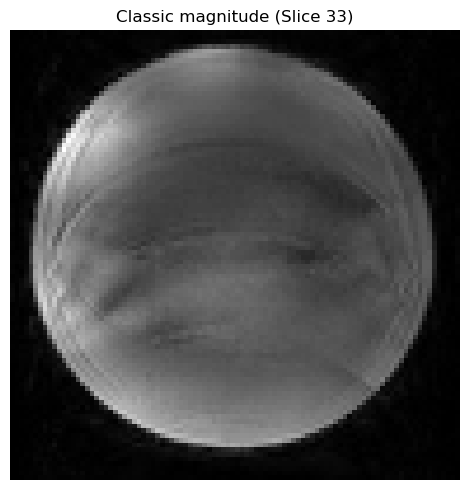

/Users/spmic/fsl/lib/python3.11/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/Users/spmic/fsl/lib/python3.11/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


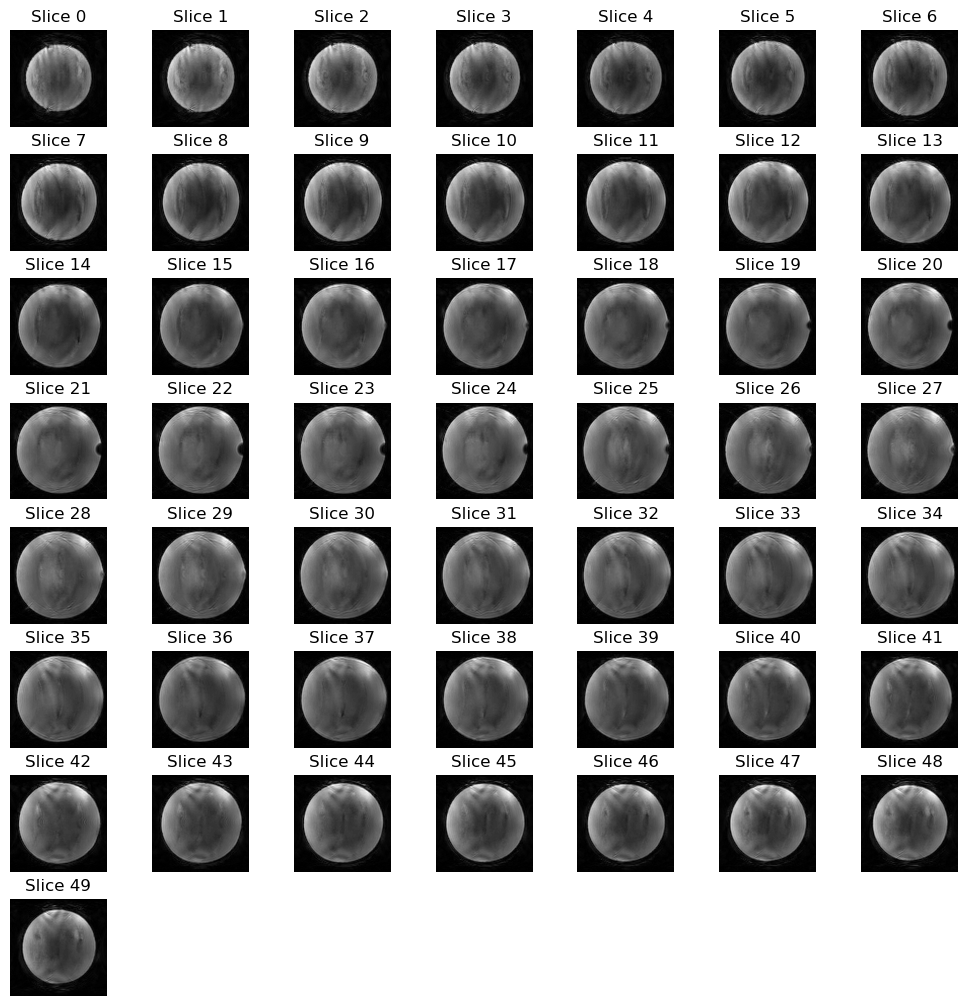

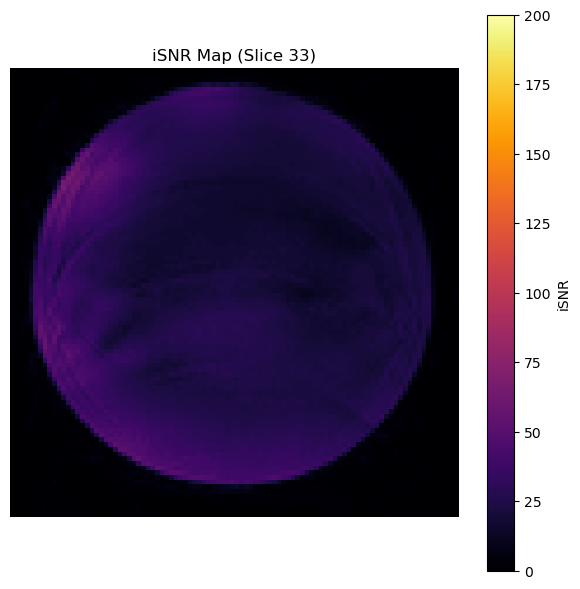

(96, 96, 50)


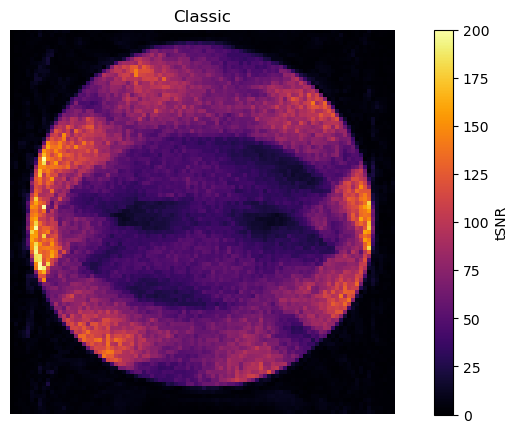

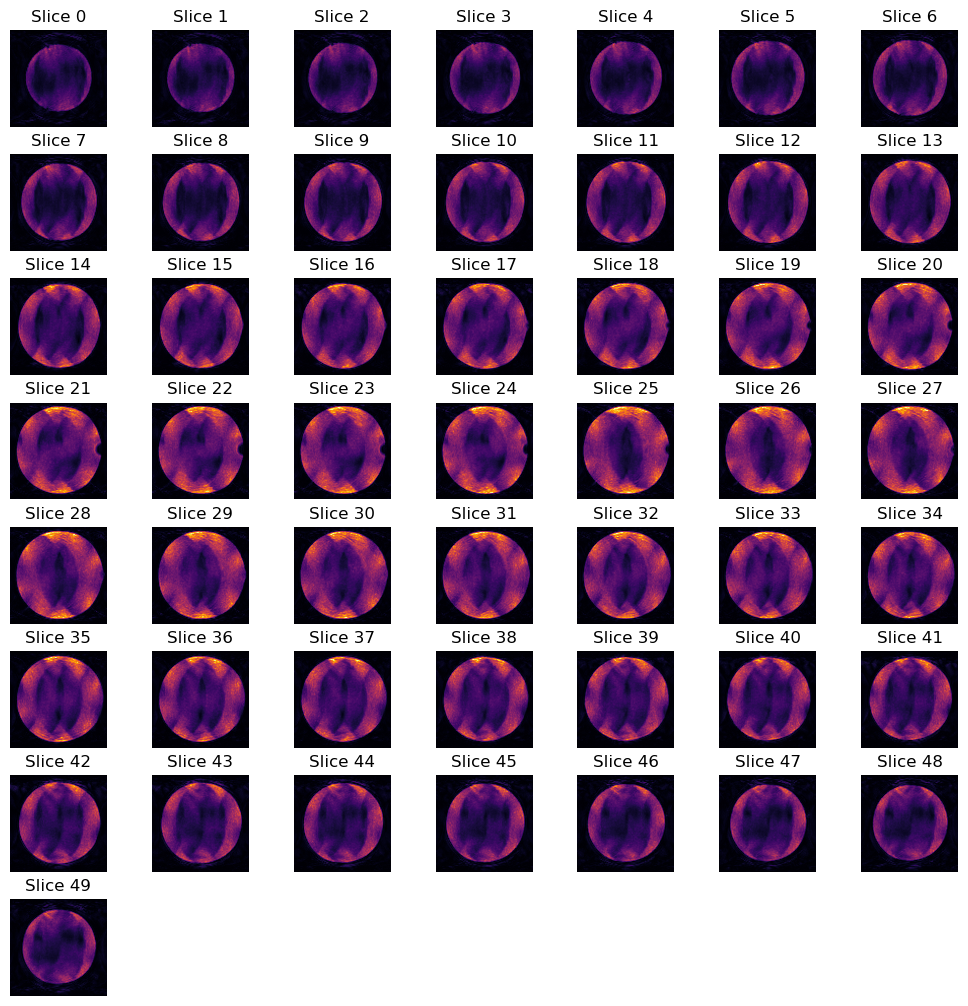

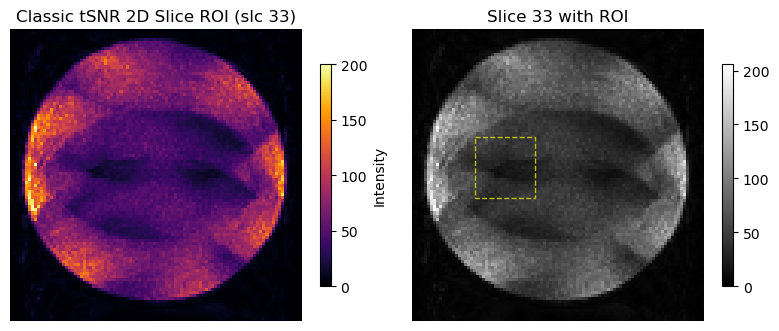

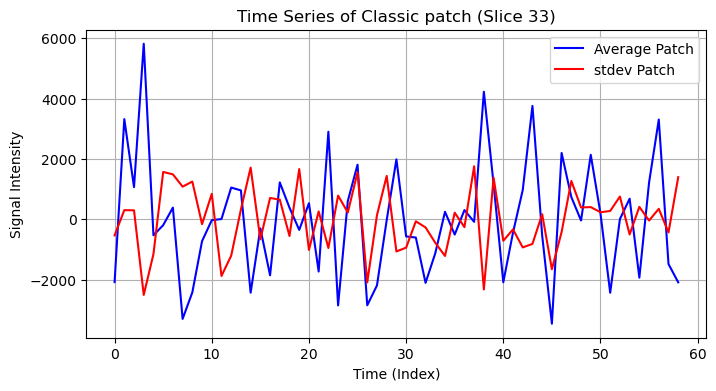

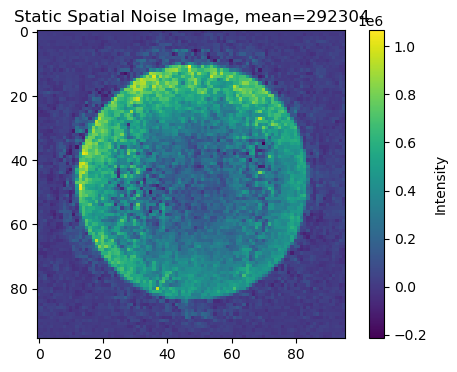

Checking phase file path: /Users/spmic/data/preDUST_FUNSTAR/FUNSTAR_QA_240125_MTX/phase/FUNSTAR_QA_240125_MTX_2DEPI_MB2_50slc_rsfMRI_2mm_iso_TR1p5_20250124152641_13_clv_ph.nii
Phase file NOT found: /Users/spmic/data/preDUST_FUNSTAR/FUNSTAR_QA_240125_MTX/phase/FUNSTAR_QA_240125_MTX_2DEPI_MB2_50slc_rsfMRI_2mm_iso_TR1p5_20250124152641_13_clv_ph.nii
Loading just mag
/Users/spmic/data/preDUST_FUNSTAR/FUNSTAR_QA_240125_MTX/raw_clv/FUNSTAR_QA_240125_MTX_2DEPI_MB2_50slc_rsfMRI_2mm_iso_TR1p5_20250124152641_13_clv.nii.gz
Slice index: 33


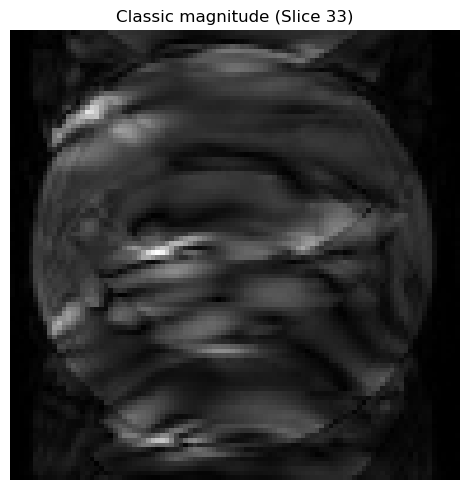

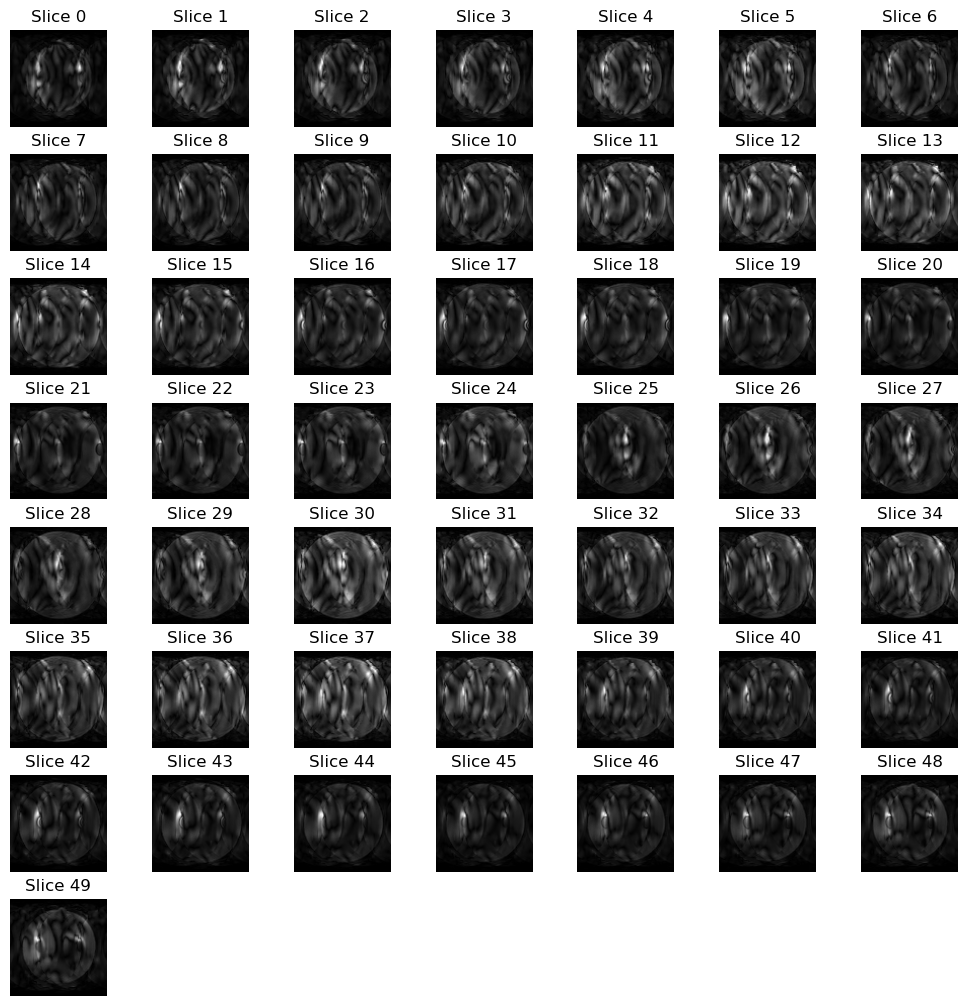

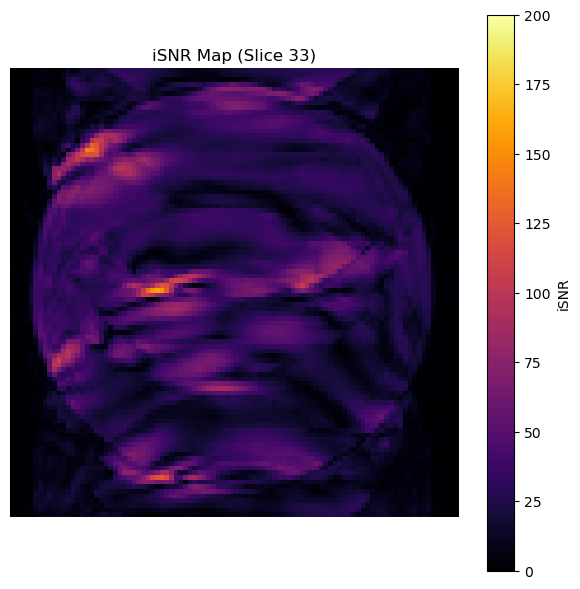

(96, 96, 50)


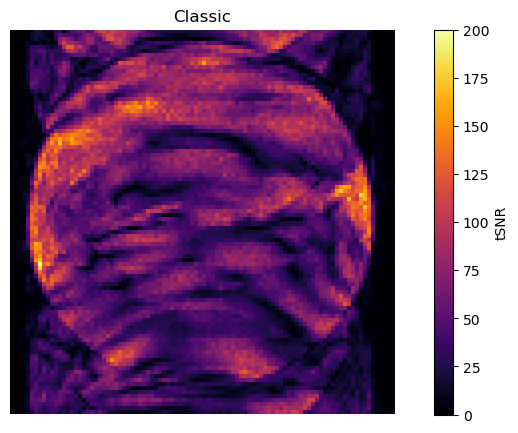

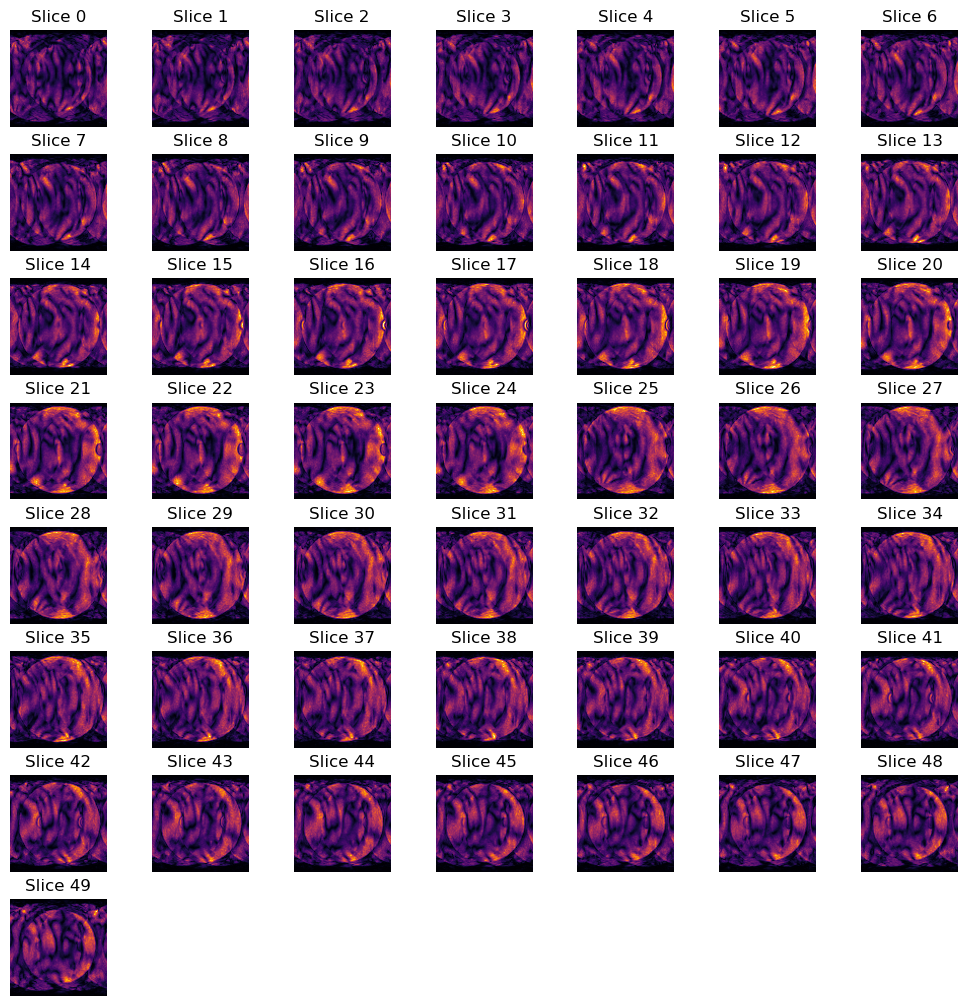

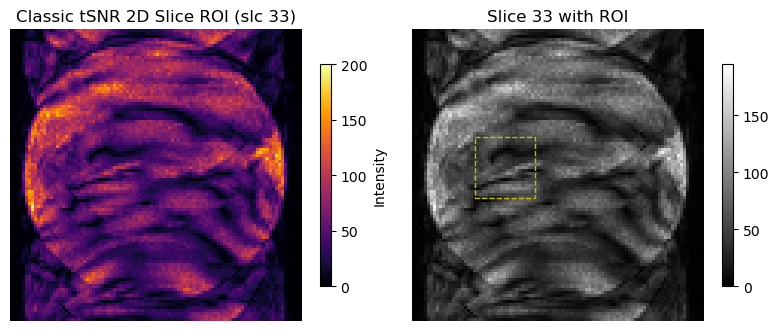

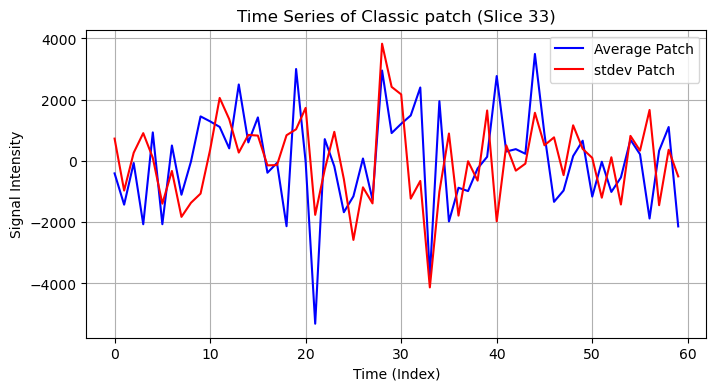

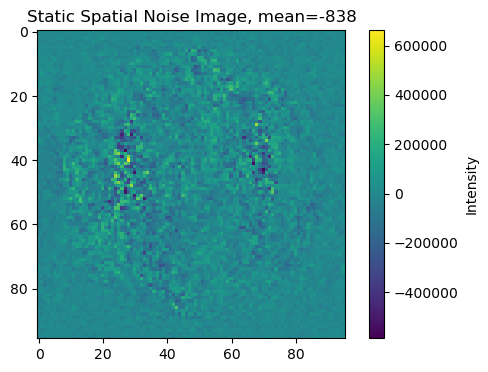

Checking phase file path: /Users/spmic/data/preDUST_FUNSTAR/FUNSTAR_QA_240125_MTX/phase/FUNSTAR_QA_240125_MTX_2DEPI_MB0_17slc_1p25mm_iso_TR2_20250124152641_11_clv_ph.nii
Phase file NOT found: /Users/spmic/data/preDUST_FUNSTAR/FUNSTAR_QA_240125_MTX/phase/FUNSTAR_QA_240125_MTX_2DEPI_MB0_17slc_1p25mm_iso_TR2_20250124152641_11_clv_ph.nii
Loading just mag
/Users/spmic/data/preDUST_FUNSTAR/FUNSTAR_QA_240125_MTX/raw_clv/FUNSTAR_QA_240125_MTX_2DEPI_MB0_17slc_1p25mm_iso_TR2_20250124152641_11_clv.nii.gz
Slice index: 11


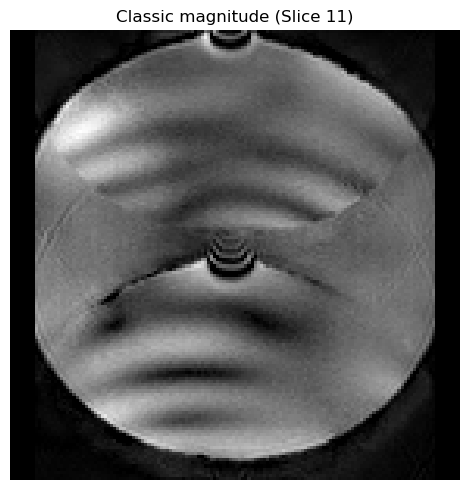

/Users/spmic/fsl/lib/python3.11/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/Users/spmic/fsl/lib/python3.11/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


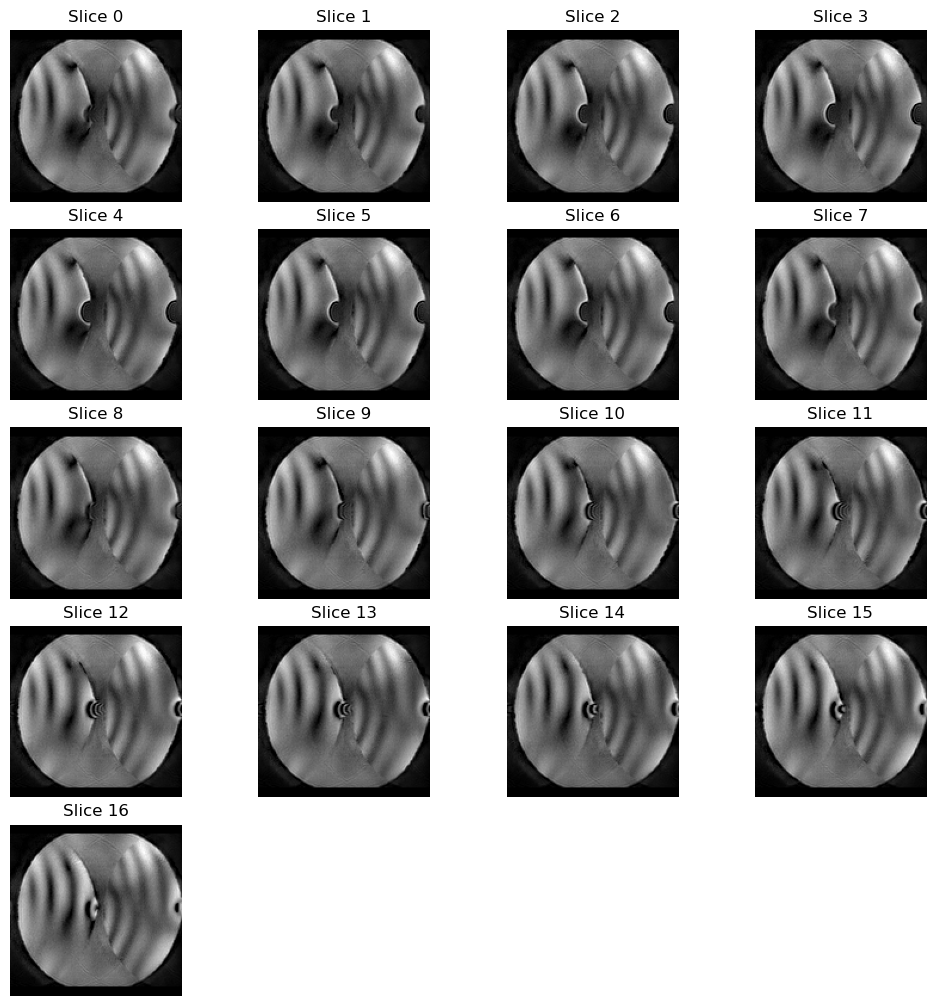

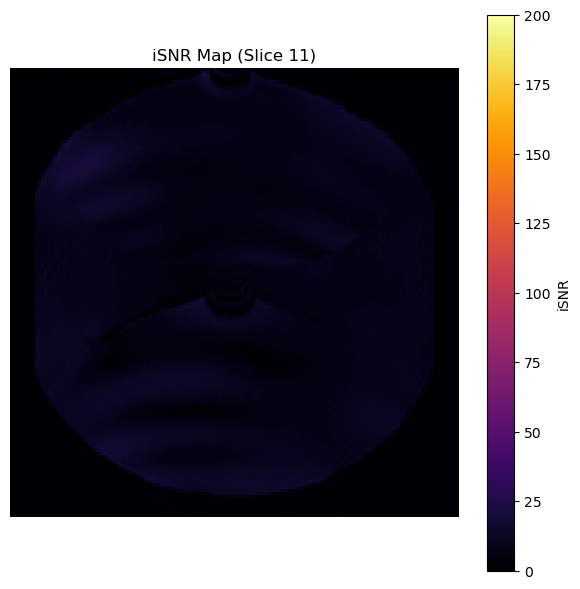

(144, 144, 17)


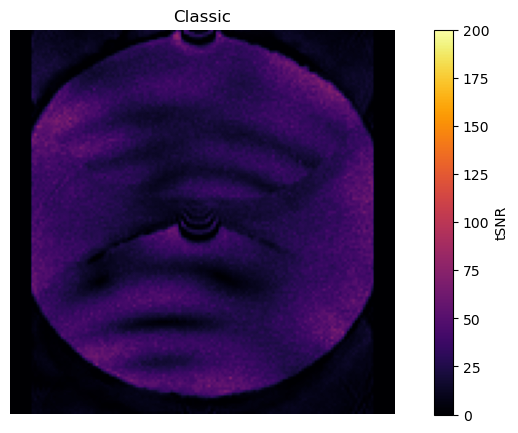

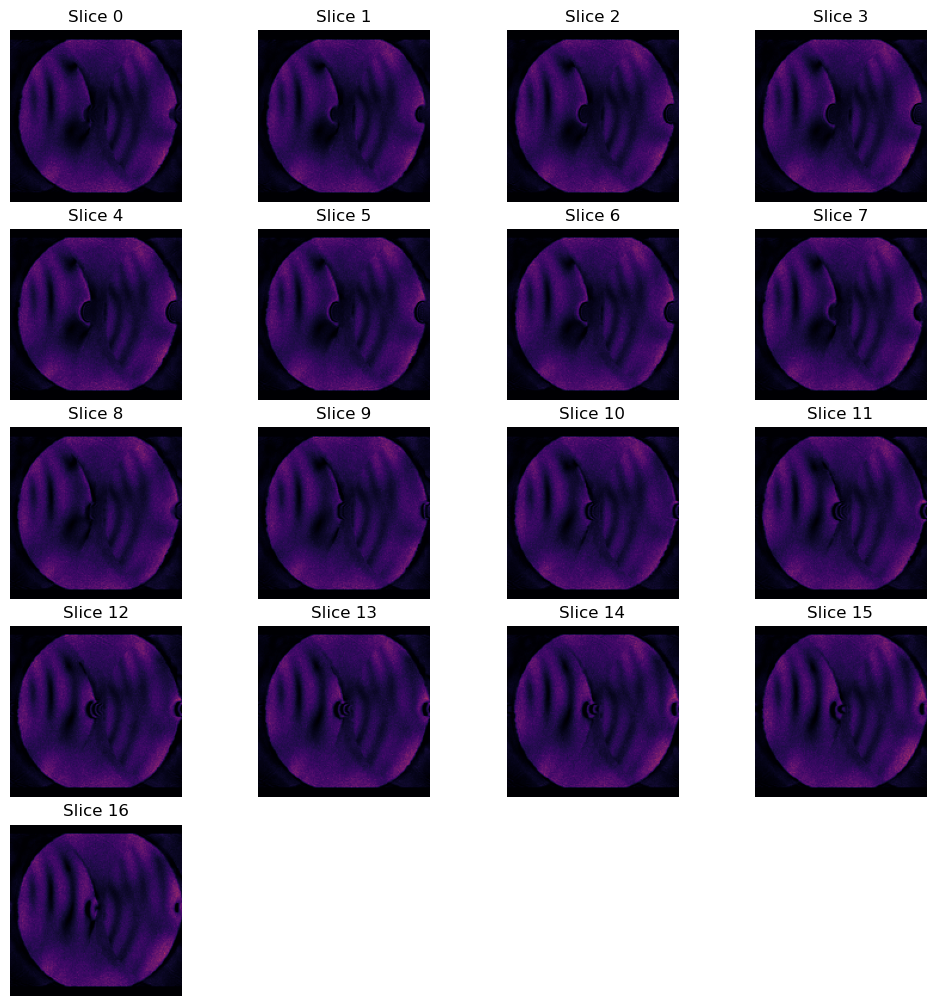

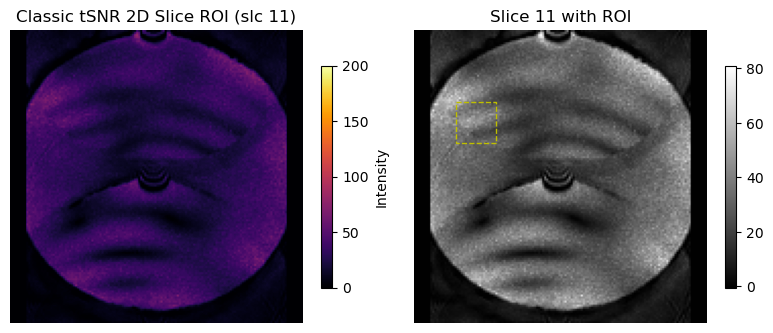

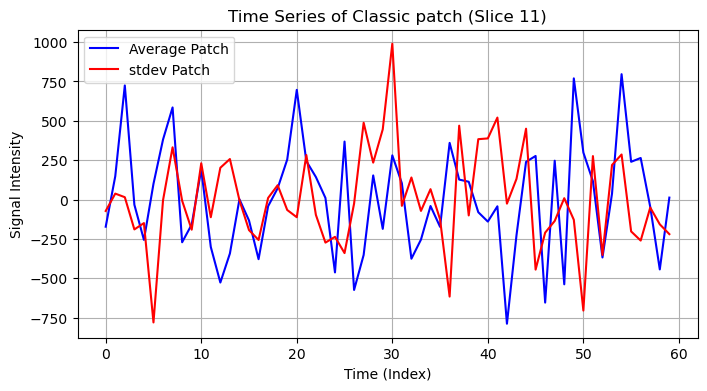

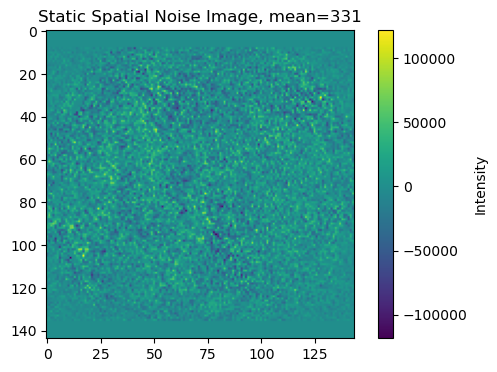

Checking phase file path: /Users/spmic/data/preDUST_FUNSTAR/FUNSTAR_QA_240125_MTX/phase/FUNSTAR_QA_240125_MTX_2DEPI_MB0_17slc_1p25mm_iso_TR2_20250124152641_16_clv_ph.nii
Phase file NOT found: /Users/spmic/data/preDUST_FUNSTAR/FUNSTAR_QA_240125_MTX/phase/FUNSTAR_QA_240125_MTX_2DEPI_MB0_17slc_1p25mm_iso_TR2_20250124152641_16_clv_ph.nii
Loading just mag
/Users/spmic/data/preDUST_FUNSTAR/FUNSTAR_QA_240125_MTX/raw_clv/FUNSTAR_QA_240125_MTX_2DEPI_MB0_17slc_1p25mm_iso_TR2_20250124152641_16_clv.nii.gz
Slice index: 11


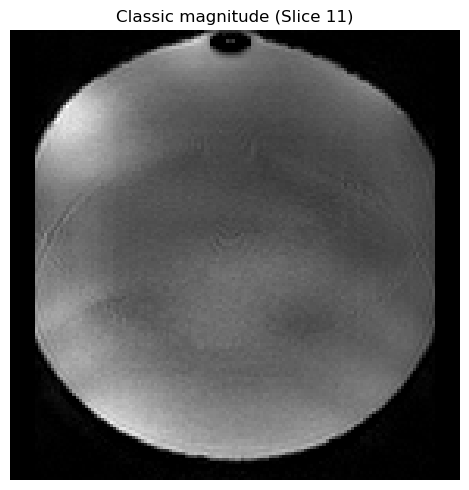

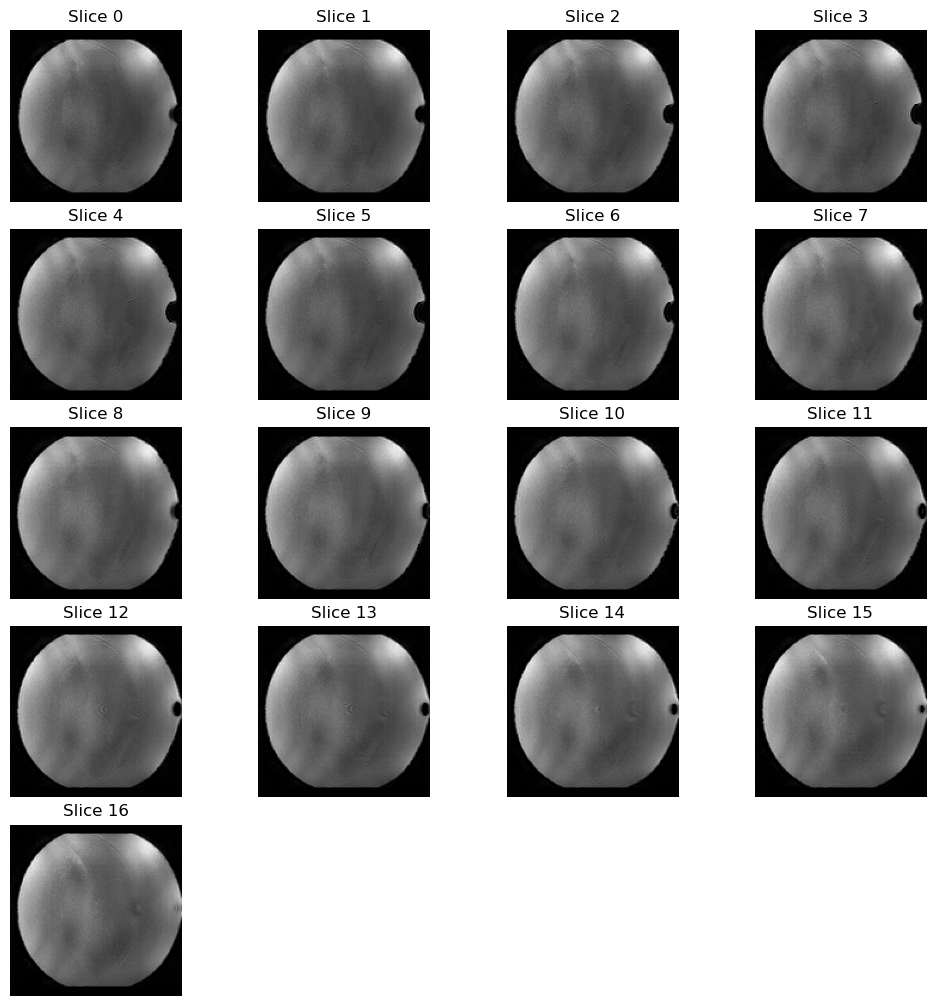

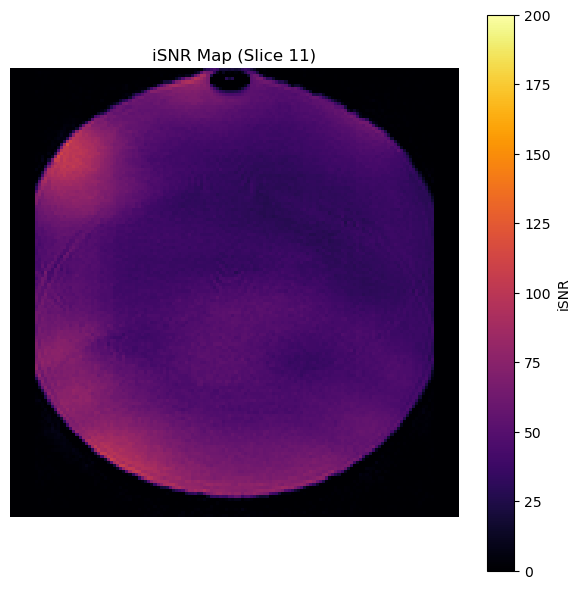

(144, 144, 17)


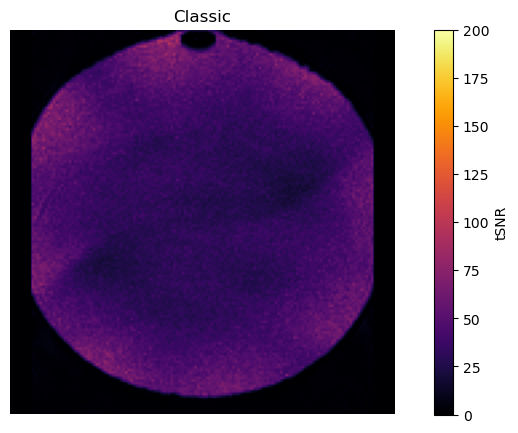

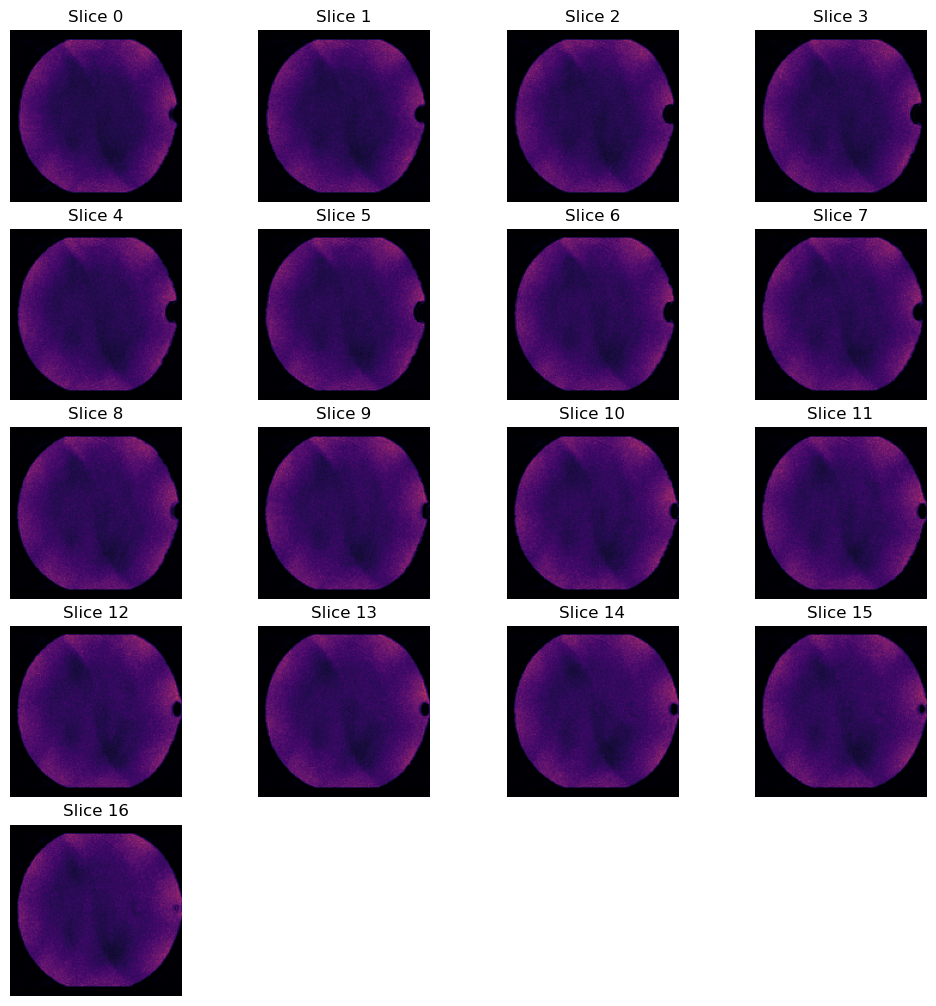

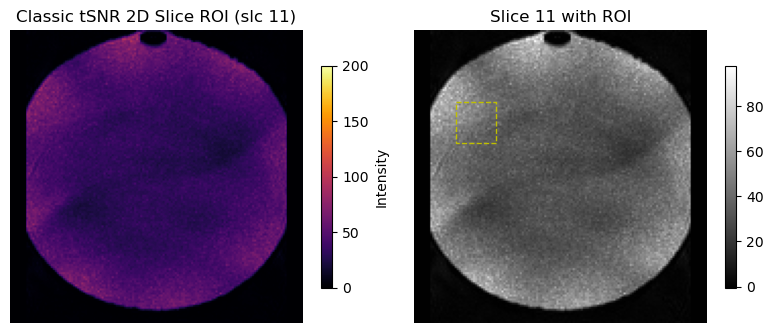

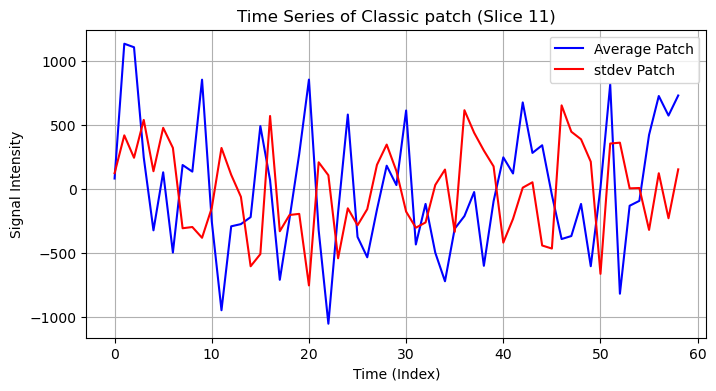

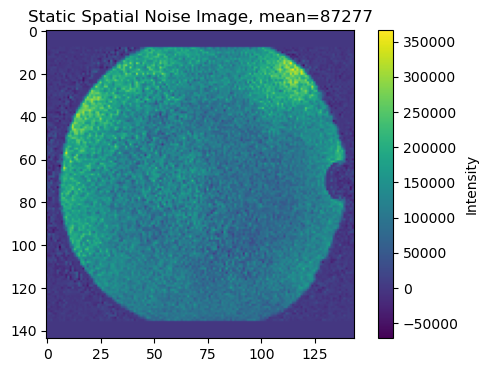

In [5]:
# Location of data
#pathname = '/Users/spmic/Documents/MATLAB/qa/fMRI_report_python/data/'

mypathname = '/Users/spmic/data/preDUST_FUNSTAR/FUNSTAR_QA_240125_MTX/'
#pathname_m = mypathname + 'magnitude/nordic_clv/middle24slices/'
pathname_m = mypathname + 'raw_clv/'
pathname_p = mypathname + 'phase/'
#pathname_p = '/Volumes/DRS-7TfMRI/michael/ZESPRI/data/zespri_1B/nback/phase/'

# Search pattern for filenames
#filename_pattern = 'FUNSTAR_classic*'
#filename_pattern = 'parrec_WIPN-BACK*'
filename_pattern = 'FUNSTAR*'

# Find all core filenames matching the pattern in the specified directory
#core_filenames = set(os.path.splitext(os.path.basename(file_path))[0] for file_path in glob(os.path.join(pathname_m, filename_pattern)))

core_filenames = set(
    os.path.splitext(os.path.splitext(os.path.basename(file_path))[0])[0]  # Handle double extensions
    for file_path in glob(os.path.join(pathname_m, filename_pattern))
)


# Loop over each core filename found
for core_filename in core_filenames:

    # Create an output directory for saving plots
    output_directory = mypathname + 'qa_output_' + core_filename
    os.makedirs(output_directory, exist_ok=True)
    OUTPUT_DIR = os.path.abspath(output_directory)

    # Open a text file for storing script outputs
    output_file_path = os.path.join(OUTPUT_DIR, 'script_outputs.txt')
    output_file = open(output_file_path, 'w')  # Open the file in write mode

    # Create a dictionary to store loaded data for each core filename
    file_data = {}

    # Find the corresponding magnitude (.nii) and phase (_ph.nii) files for the current core filename
    mag_file_path = os.path.join(pathname_m, core_filename + '.nii.gz')
    #print(mag_file_path)
    phase_file_path = os.path.join(pathname_p, core_filename + '_ph.nii')
    print(f"Checking phase file path: {phase_file_path}")  # Debugging
    if os.path.exists(phase_file_path):
        print(f"Phase file found: {phase_file_path}")
    else:
        print(f"Phase file NOT found: {phase_file_path}")

        # Check if both magnitude and phase files exist for the current core filename
    if os.path.exists(mag_file_path) and os.path.exists(phase_file_path):
        # Load magnitude and phase data for the current core filename
        print('Loading both mag and phase')
        imgm_cla, imgm_cla_affine = load_data(mag_file_path)
        imgp_cla, imgp_cla_affine = load_data(phase_file_path)

        print(mag_file_path)
        print(phase_file_path)
        
        # Store loaded data in the dictionary with the core filename as the key
        file_data[core_filename] = (imgm_cla, imgp_cla)

        # Process and plot data
        process_data(imgm_cla, imgp_cla, imgm_cla_affine, imgp_cla_affine, core_filename, OUTPUT_DIR)

        # Close the text file after writing all outputs
        output_file.close()
    else:
        # Load magnitude data only
        print('Loading just mag')
        imgm_cla, imgm_cla_affine = load_data(mag_file_path)
        #imgp_cla, imgp_cla_affine = load_data(phase_file_path)

        print(mag_file_path)
        #print(phase_file_path)
        
        # Store loaded data in the dictionary with the core filename as the key
        file_data[core_filename] = (imgm_cla)

        # Process and plot data
        process_data_nophase(imgm_cla, imgm_cla_affine, core_filename, OUTPUT_DIR)

        # Close the text file after writing all outputs
        output_file.close()
        
        

    



## Image Signal to Noise Ratio (iSNR)
There is no standardised method to measure iSNR within the MRI community, as such `ukat` simply aims to provide a highly repeatable method that allows for a direct comparison between acquisitions rather than a comparison between different
studies/modalities. A concise introduction to iSNR measurements in MRI can be found [here](http://mriquestions.com/signal-to-noise.html).



The iSNR calculation `ukat` performs is $\textrm{iSNR} = \frac{Mean\left(\textrm{Foreground Voxels}\right)}{\sigma\left
(\textrm{Background Voxels}\right)} \times \sqrt{2 - \frac{\pi}{2}}$. To do this we need to segment the image into
background and foreground voxels.
This mask can either be supplied manually or estimated by the `Isnr` class. Let's start by demonstrating the simplest way
the `Isnr` class can work before exploring the automatic background segmentation in more depth.

For fMRI data, I have ignored the segmentation step, so it is just doing the signal/noise step + the extra sqrt pi section (Rician factor)

Additionally, iSNR maps can be generated. These are calculated by dividing the image by the standard deviation of the noise and multiplying it by the Rician correction factor. This is useful for visualising the noise in the image.

## Temporal Signal to Noise Ratio (tSNR)
Here, we calculate tSNR (mean/std over time, voxelwise).

Each dataset will be fetched, a tSNR map calculated and the output saved as a nifti. The resulting tSNR maps will also be displayed in this notebook.

Just try plotting the timeseries and std